In [1]:
import torch 
import numpy as np
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(4, 4)})

import warnings

warnings.filterwarnings('ignore')


In [2]:
batch_size = 3
start      = 0.0
end        = 1.4

In [3]:
def exact_solution(t,x):
    return np.exp(-t)*np.sin(np.pi*x)


def sample_dataset(noise=0.1, numSamples = 100):
    
    x = np.linspace(-1, 1, numSamples).reshape(-1,1) # Space domain
    t = np.linspace(0, 1, numSamples).reshape(-1,1) # Time domain
    
    X, T = np.meshgrid(x, t) # space-time domain

    y_true = exact_solution(T, X)
    T      = T.reshape(-1,1)
    X      = X.reshape(-1,1)
    sample_mean = y_true.reshape(-1,1)
    sample_var  = noise*np.ones_like(sample_mean) 
    # sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    Y_noisy     = stats.norm(sample_mean, sample_var).rvs(random_state=1)

    return T, X, Y_noisy


def create_train_test_datasets():
    t_train, x_train, y_train = sample_dataset(noise=0.01, numSamples=10)
    t_test, x_test, y_test    = sample_dataset(noise=0.0, numSamples = 100)
    
    fig = plt.figure()
    size = int(np.sqrt(x_test.shape[0]))
    
    plt.contourf(t_test.reshape(size,size),
                x_test.reshape(size,size),
                y_test.reshape(size,size))
    plt.xlabel('t'); plt.ylabel('x'); 
    plt.colorbar()

    train_dataset = TensorDataset(torch.tensor(t_train),
                                  torch.tensor(x_train),
                                  torch.tensor(y_train))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    
    # Test
    test_dataset =  TensorDataset(torch.tensor(t_test),
                                  torch.tensor(x_test),
                                  torch.tensor(y_test))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

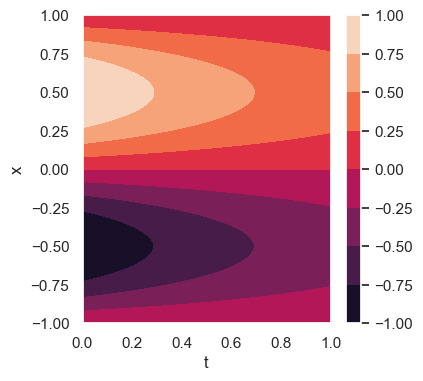

In [20]:
train_loader, test_loader = create_train_test_datasets()

In [116]:
class Experiment(nn.Module):
    def __init__(self):
        super(Experiment, self).__init__()

        self.optimizer = None
        self.train_loss_history = []
        self.w_ic   =  1   # w for initial condition 
        self.w_int  = 1   # w for internal term of the loss function (data free)
        self.w_data = 1   # weight for the term in loss function corresponding to data 
        self.w_bc   = 1   # boundary condition
        self.numInputs = 2
        self.numParams = 2
        self.numOutputs = 1
        
        
        self.hidden_size = 25
        
        self.t0 = torch.tensor([0.0], requires_grad=True).to(device)
        self.y0 = torch.tensor([1.0], requires_grad=True).to(device) #??
        
        self.predicted_params = torch.zeros(self.numParams, requires_grad=True)
    

        # We only have 1 input feature
        self.b1 = nn.Linear(self.numInputs, self.hidden_size ).to(device)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size).to(device)
        self.b3 = nn.Linear(self.hidden_size, self.numOutputs).to(device)

        self.t1 = nn.Linear(1, self.hidden_size).to(device)
        self.t2 = nn.Linear(self.hidden_size, self.hidden_size).to(device)
        self.t3 = nn.Linear(self.hidden_size, self.numParams).to(device)
        
        nn.init.ones_(self.b1.weight)
        nn.init.ones_(self.b2.weight)
        nn.init.ones_(self.b3.weight)
        
        nn.init.ones_(self.t1.weight)
        nn.init.ones_(self.t2.weight)
        nn.init.ones_(self.t3.weight)
        
    def forward(self, t, x):
        if not torch.is_tensor(t):         
            t = torch.from_numpy(t)              
        
        if not torch.is_tensor(x):         
            x = torch.from_numpy(x).to(device)               

        t = t.float().to(device)
        x = x.float().to(device)
        
        input = torch.cat((t, x), 1)
        
        h1 = torch.tanh(self.b1(input))
        h2 = torch.tanh(self.b2(h1))

        prior_param_sample = torch.rand(1,1).to(device).requires_grad_(True)

        t1 = torch.tanh(self.t1(prior_param_sample))
        t2 = torch.tanh(self.t2(t1))
        posterior_param_sample =  self.t3(t2)
        self.predicted_params  =  posterior_param_sample.squeeze()
        # posterior_param_sample = self.t3(torch.multiply(t2,h2))
        
        y  = self.b3(torch.multiply(t2,h2))
        
        return y

    def sample_parameter_posterior(self, num_samples=100):
        prior_param_sample     = torch.rand(num_samples,1).to(device).requires_grad_(True)
        posterior_param_sample = \
           self.t3(torch.tanh(self.t2(torch.tanh(self.t1(prior_param_sample)))))
        
        return posterior_param_sample
        
    def compute_derivative(self, y, x, n):
        # General formula to compute the n-th order derivative of y = f(x) with respect to x
        if n == 0:
            return y
        else:
            dy_dx = torch.autograd.grad(y, x, torch.ones_like(y).to(device),
                                        create_graph=True, retain_graph=True,
                                        allow_unused=True)[0]
            
        return self.compute_derivative(dy_dx, x, n - 1)

    def PDE_residual(self, t, x):
        # Compute the differential equation residual
        y        = self.forward(t,x)
        dy_dt    = self.compute_derivative(y, t, 1)
        dy_dx    = self.compute_derivative(y, x, 1)
        d2y_dx2  = self.compute_derivative(y, x, 2)

        residual = dy_dt - self.predicted_params[1]*d2y_dx2  \
                   + torch.exp(- self.predicted_params[0]*t)*(torch.sin(np.pi*x) - np.pi*np.pi*torch.sin(np.pi*x))
        
        return residual

    def loss_initial_condition(self, num_samples = 200):
        y0         = self.y0 * torch.ones((num_samples,1)).to(device) ## Need to get this from exact sol
        t0         = self.t0 * torch.ones((num_samples,1)).to(device)
        x          = torch.FloatTensor(num_samples,1).uniform_(-1, 1).to(device).requires_grad_(True)
        y0_pred    = self.forward(t0,x)
        loss_ic    = torch.mean(torch.square( y0 - y0_pred))
        
        return loss_ic

    def loss_boundary_condition(self, num_samples = 200):
        x_low      = -1
        x_high     =  1
        xb_low     = x_low  * torch.ones((num_samples,1))
        xb_high    = x_high * torch.ones((num_samples,1))
        t          = torch.FloatTensor(num_samples,1).uniform_(-1, 1)
        
        yb_low     = torch.tensor(exact_solution(t.numpy(),xb_low.numpy())) # this is correct
        yb_high    = torch.tensor(exact_solution(t.numpy(),xb_high.numpy()))
        
        yb_pred_low    = self.forward(t,xb_low)
        yb_pred_high   = self.forward(t,xb_high)
        
        loss_ic    = torch.mean(torch.square( yb_pred_low - yb_low)) \
                   + torch.mean(torch.square( yb_pred_high - yb_high))
        
        return loss_ic

    def compute_losses(self):

        loss_ic       = self.loss_initial_condition()
        loss_interior = self.loss_interior()
        loss_data     = self.loss_data()
        loss_bc       = self.loss_boundary_condition()

        return loss_ic, loss_interior, loss_data, loss_bc


    def loss_data(self, num_samples = 100):
        # t_data = torch.linspace(0,1,num_samples).reshape(-1,1).to(device).requires_grad_(True)
        # y_data = torch.exp(-2.0*t_data) 
        t_data, x_data, y_data = next(iter(train_loader))
        y_pred = self.forward(t_data, x_data)
        loss   = torch.mean(torch.square(y_pred-y_data))
        
        return loss
        
    def loss_interior(self, num_samples = 800):
        interior_t_samples = torch.FloatTensor(num_samples, 1).uniform_(0, 1).to(device).requires_grad_(True)
        interior_x_samples = torch.FloatTensor(num_samples, 1).uniform_(-1, 1).to(device).requires_grad_(True)
        
        res           = self.PDE_residual(interior_t_samples, interior_x_samples)
        loss_residual = torch.mean(torch.square(res))
        
        return loss_residual
        
    def closure(self):
        self.optimizer.zero_grad()
        loss_ic, loss_interior, loss_data, loss_bc = self.compute_losses()
        total_loss = self.w_ic*loss_ic \
                   + self.w_int*loss_interior\
                   + self.w_data*loss_data \
                   + self.w_bc*loss_bc
        
        total_loss.backward(retain_graph=True)
        
        return total_loss

    def train(self, epochs, optimizer='Adam', **kwargs):

        if optimizer=='Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), **kwargs)

        elif optimizer=='L-BFGS':
            self.optimizer = torch.optim.LBFGS(self.parameters(), **kwargs)

        # Training loop
        for epoch in range(epochs):


            self.optimizer.step(self.closure)

            if epoch % 4000 == 0:
                loss_ic, loss_interior, loss_data, loss_bc = self.compute_losses()
                total_loss = loss_ic + loss_interior + loss_data + loss_bc

                print(f'Epoch ({optimizer}): {epoch}, Total Loss: {total_loss.detach().cpu().numpy()}')
                
    def make_plot(self):
        
        t_test, x_test, y_test    = sample_dataset(noise=0.0)
        mu = self.forward(t_test, x_test)
        
        fig = plt.figure(figsize=(6,3))
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122, sharex = ax1)
        size = int(np.sqrt(x_test.shape[0]))
        
        ax1.contourf(t_test.reshape(size,size),
                     x_test.reshape(size,size),
                     mu.detach().numpy().reshape(size,size))
        plt.xlabel('t'); plt.ylabel('x'); 
        ax1.get_shared_x_axes().join(ax1, ax2)

        ax2.contourf(t_test.reshape(size,size),
                     x_test.reshape(size,size),
                     y_test.reshape(size,size))

        
        # plt.colorbar();
            
    # def get_training_history(self):
    #     loss_hist = np.array(self.train_loss_history)
    #     total_loss, loss_ic, loss_interior, loss_data = np.split(loss_hist, 3, axis=1)
    #     return total_loss, loss_ic, loss_interior, loss_data

        
    # def compute_Jacobina(self, x):
    #     self.dy_dx = torch.autograd.functional.jacobian(self, x, create_graph=True)
    #     self.dy_dx = torch.squeeze(self.dy_dx)
    #     return self.dy_dx


In [117]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# note higher order derivatives not working on mps 
# havent checkd on gpu 


cpu


In [118]:
net = Experiment()
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

Params: 1503


In [119]:
net.w_ic=1
net.w_data =1

In [126]:
net.train(20000, lr=1e-2)

Epoch (Adam): 0, Total Loss: 16.658046543887885
Epoch (Adam): 4000, Total Loss: 0.1470076275913249
Epoch (Adam): 8000, Total Loss: 0.6956964410513672
Epoch (Adam): 12000, Total Loss: 0.29490967542730095
Epoch (Adam): 16000, Total Loss: 0.684932859596283


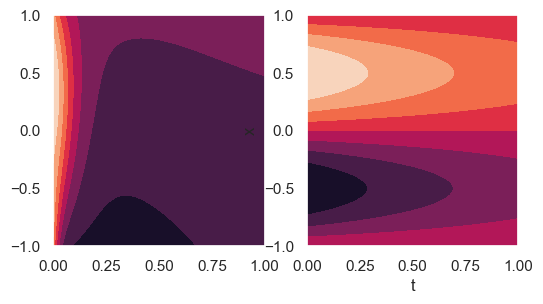

In [127]:
net.make_plot()
samples = net.sample_parameter_posterior(num_samples=1000).detach().cpu()

In [123]:
samples

tensor([[12.7249,  1.8376],
        [12.6429,  1.8250],
        [12.5638,  1.8112],
        ...,
        [12.6770,  1.8304],
        [12.7142,  1.8361],
        [12.6473,  1.8257]])

In [124]:
samples.mean(axis=0), samples.std(axis=0)

(tensor([12.6412,  1.8240]), tensor([0.0775, 0.0129]))

tensor([18.7890,  8.7536], grad_fn=<SqueezeBackward0>)

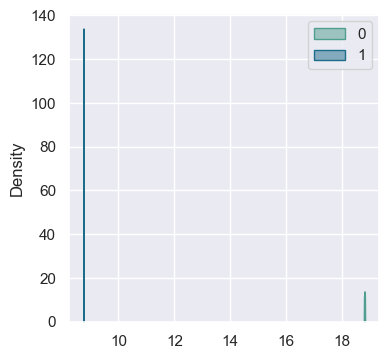

In [128]:
g  = sns.kdeplot(samples, fill=True, palette="crest",
                 alpha=.5, linewidth=1)
net.predicted_params

In [14]:
x,t, y  = next(iter(train_loader))
net(t, x) - exact_solution(t,x
                          )

tensor([[-0.7341],
        [ 0.2527],
        [-2.0384]], dtype=torch.float64, grad_fn=<SubBackward0>)

In [17]:
x = np.linspace(-1, 1, 100).reshape(-1,1) # Space domain
t = np.linspace(0, 1, 100).reshape(-1,1) # Time domain

X, T = np.meshgrid(x[:, 0], t[:, 0]) # space-time domain

y_true = exact_solution(T, X)

In [18]:
net(t,x);